In [ ]:
! rm -rf data/lego-minifigures-classification
# ! pip install kaggle
# ! kaggle datasets download -d ihelon/lego-minifigures-classification -p data/
! unzip data/archive.zip -d data/lego-minifigures-classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import cv2
import shutil
import os
from PIL import Image

argument = {
    "rotation_range":30,
    "horizontal_flip":True, 
    "vertical_flip": True
}

In [ ]:
root_path = "data/lego-minifigures-classification/"
train_set = pd.read_csv(root_path+"index.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)
metadata = pd.read_csv(root_path+"metadata.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)
test_set = pd.read_csv(root_path+"test.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)
train_set.class_id = train_set.class_id.map(lambda x: str(x))
test_set.class_id = test_set.class_id.map(lambda x: str(x))

In [ ]:
batch_size = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, **argument) \
    .flow_from_dataframe(dataframe=train_set, directory=root_path, x_col="path", y_col="class_id")
input_shape = train_batches.image_shape
num_classes = len(train_batches.class_indices)

Found 352 validated image filenames belonging to 36 classes.


In [ ]:
batch_size = 10
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_dataframe(dataframe=test_set, directory=root_path, x_col="path", y_col="class_id")
input_shape = train_batches.image_shape
num_classes = len(train_batches.class_indices)

Found 73 validated image filenames belonging to 36 classes.


In [ ]:
model2 = Sequential()
mobileNet_model = keras.applications.mobilenet.MobileNet(dropout=.5)
for layer in mobileNet_model.layers[:-1]:
  model2.add(layer)
for layer in model2.layers:
  layer.trainable = False
model2.add(keras.layers.Dense(num_classes, activation="softmax"))
# model2.summary()

In [ ]:
best_path, monitor_metric, patience_number = 'best.hdf5', 'val_accuracy', 7

In [ ]:
callback_save = tf.keras.callbacks.ModelCheckpoint(
    best_path,
    monitor_metric,
    save_best_only=True,
)

callback_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_metric,
    patience=patience_number,
)
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('val_accuracy')>=0.90):
          self.model.stop_training = True
callbacks_array = [callback_save, myCallback()]

In [ ]:
model2.compile(optimizer=Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model2.fit(x=train_batches, validation_data=test_batches, epochs=50,callbacks=callbacks_array, shuffle=False)

Epoch 1/50
11/11 [==============================] - 27s 2s/step - loss: 0.6578 - accuracy: 0.0284 - val_loss: 0.2650 - val_accuracy: 0.0411
Epoch 2/50
11/11 [==============================] - 24s 2s/step - loss: 0.2940 - accuracy: 0.0682 - val_loss: 0.2839 - val_accuracy: 0.0274
Epoch 3/50
11/11 [==============================] - 24s 2s/step - loss: 0.2734 - accuracy: 0.0938 - val_loss: 0.2373 - val_accuracy: 0.0685
Epoch 4/50
11/11 [==============================] - 24s 2s/step - loss: 0.2194 - accuracy: 0.1420 - val_loss: 0.1870 - val_accuracy: 0.1644
Epoch 5/50
11/11 [==============================] - 25s 2s/step - loss: 0.1784 - accuracy: 0.2045 - val_loss: 0.1459 - val_accuracy: 0.2055
Epoch 6/50
11/11 [==============================] - 23s 2s/step - loss: 0.1477 - accuracy: 0.2869 - val_loss: 0.1260 - val_accuracy: 0.2603
Epoch 7/50
11/11 [==============================] - 23s 2s/step - loss: 0.1308 - accuracy: 0.3239 - val_loss: 0.1188 - val_accuracy: 0.2603
Epoch 8/50
11/11 [==

In [ ]:
model_best = tf.keras.models.load_model(best_path)
y_pred = np.argmax(model_best.predict(test_batches), axis=1)

In [ ]:
labels = (test_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

In [ ]:
results=pd.DataFrame({"path": test_batches.filenames,
                      "Predictions":predictions})

In [ ]:
final_result = pd.merge(test_set[['class_id','path']], results[['path', 'Predictions']], on='path')
final_result[final_result.class_id == final_result.Predictions]

,class_id,path,Predictions
19,18,test/020.jpg,18
28,17,test/029.jpg,17
29,14,test/030.jpg,14
40,23,test/041.jpg,23


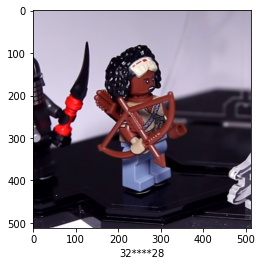

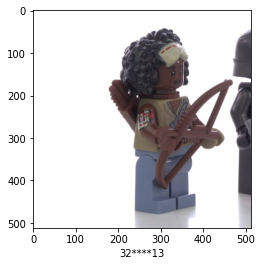

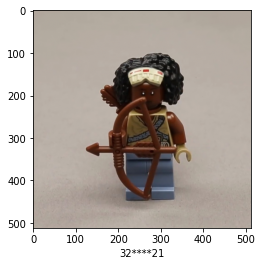

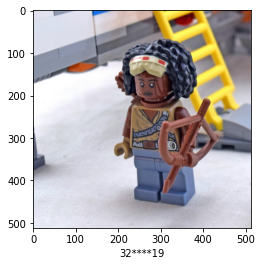

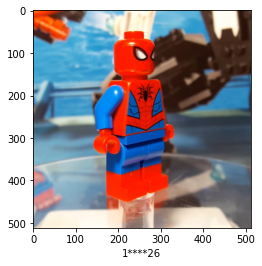

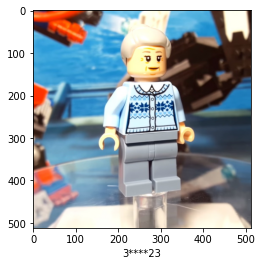

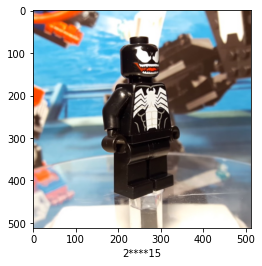

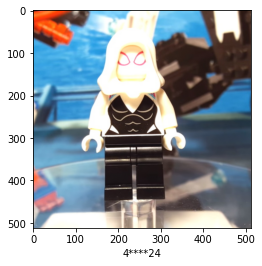

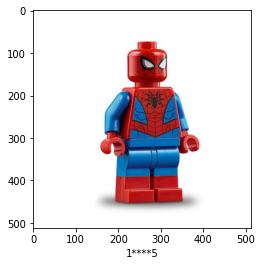

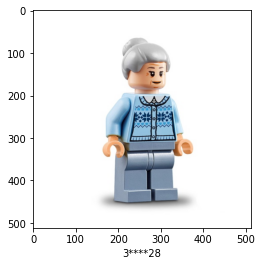

In [ ]:
for i in range(10):
  image_path = root_path+str(final_result['path'].values[i])
  image = cv2.imread(image_path)
  image = cv2.resize(image, dsize=(512,512))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
  plt.imshow(image)
  plt.xlabel(str(final_result['class_id'].values[i])+'****'+final_result['Predictions'].values[i])
  plt.show()

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('loss')<= 0.01):
          self.model.stop_training = True

model = Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))
model.compile(optimizer=Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.fit(x=train_batches, epochs=200,callbacks=callbacks_array, shuffle=False, validation_data=test_batches)